In [10]:
import scipy 
import numpy as np
import proplot as plot
import matplotlib.pyplot as plt
import noise
from scipy.signal import convolve2d
import astropy
from astropy.convolution import convolve, 

def convolve2dnan(slab,kernel,max_missing=0.5,verbose=True):
    '''2D convolution with missings ignored

    <slab>: 2d array. Input array to convolve. Can have np.nan or masked values.
    <kernel>: 2d array, convolution kernel, must have sizes as odd numbers.
    <max_missing>: float in (0,1), max percentage of missing in each convolution
                   window is tolerated before a missing is placed in the result.

    Return <result>: 2d array, convolution result. Missings are represented as
                     np.nans if they are in <slab>, or masked if they are masked
                     in <slab>.

    '''

    from scipy.ndimage import convolve as sciconvolve

    assert np.ndim(slab)==2, "<slab> needs to be 2D."
    assert np.ndim(kernel)==2, "<kernel> needs to be 2D."
    assert kernel.shape[0]%2==1 and kernel.shape[1]%2==1, "<kernel> shape needs to be an odd number."
    assert max_missing > 0 and max_missing < 1, "<max_missing> needs to be a float in (0,1)."

    #--------------Get mask for missings--------------
    if not hasattr(slab,'mask') and np.any(np.isnan(slab))==False:
        has_missing=False
        slab2=slab.copy()

    elif not hasattr(slab,'mask') and np.any(np.isnan(slab)):
        has_missing=True
        slabmask=np.where(np.isnan(slab),1,0)
        slab2=slab.copy()
        missing_as='nan'

    elif (slab.mask.size==1 and slab.mask==False) or np.any(slab.mask)==False:
        has_missing=False
        slab2=slab.copy()

    elif not (slab.mask.size==1 and slab.mask==False) and np.any(slab.mask):
        has_missing=True
        slabmask=np.where(slab.mask,1,0)
        slab2=np.where(slabmask==1,np.nan,slab)
        missing_as='mask'

    else:
        has_missing=False
        slab2=slab.copy()

    #--------------------No missing--------------------
    if not has_missing:
        result=sciconvolve(slab2,kernel,mode='constant',cval=0.)
    else:
        H,W=slab.shape
        hh=int((kernel.shape[0]-1)/2)  # half height
        hw=int((kernel.shape[1]-1)/2)  # half width
        min_valid=(1-max_missing)*kernel.shape[0]*kernel.shape[1]

        # dont forget to flip the kernel
        kernel_flip=kernel[::-1,::-1]

        result=sciconvolve(slab2,kernel,mode='constant',cval=0.)
        slab2=np.where(slabmask==1,0,slab2)

        #------------------Get nan holes------------------
        miss_idx=zip(*np.where(slabmask==1))

        if missing_as=='mask':
            mask=np.zeros([H,W])

        for yii,xii in miss_idx:

            #-------Recompute at each new nan in result-------
            hole_ys=range(max(0,yii-hh),min(H,yii+hh+1))
            hole_xs=range(max(0,xii-hw),min(W,xii+hw+1))

            for hi in hole_ys:
                for hj in hole_xs:
                    hi1=max(0,hi-hh)
                    hi2=min(H,hi+hh+1)
                    hj1=max(0,hj-hw)
                    hj2=min(W,hj+hw+1)

                    slab_window=slab2[hi1:hi2,hj1:hj2]
                    mask_window=slabmask[hi1:hi2,hj1:hj2]
                    kernel_ij=kernel_flip[max(0,hh-hi):min(hh*2+1,hh+H-hi), 
                                     max(0,hw-hj):min(hw*2+1,hw+W-hj)]
                    kernel_ij=np.where(mask_window==1,0,kernel_ij)

                    #----Fill with missing if not enough valid data----
                    ksum=np.sum(kernel_ij)
                    if ksum<min_valid:
                        if missing_as=='nan':
                            result[hi,hj]=np.nan
                        elif missing_as=='mask':
                            result[hi,hj]=0.
                            mask[hi,hj]=True
                    else:
                        result[hi,hj]=np.sum(slab_window*kernel_ij)

        if missing_as=='mask':
            result=np.ma.array(result)
            result.mask=mask

    return result

In [61]:
frames_ = world.filled(np.nan)
frames_complex = np.zeros_like(frames_, dtype=np.complex64)
frames_complex[np.isnan(frames_)] = np.array((1j))
frames_complex[np.bitwise_not(np.isnan(frames_))] = frames_[np.bitwise_not(np.isnan(frames_))]
convolution = signal.convolve(frames_complex, gaussian_window, 'valid')
convolution[np.imag(convolution)>0.2] = np.nan
convolution = convolution.astype(np.float32)

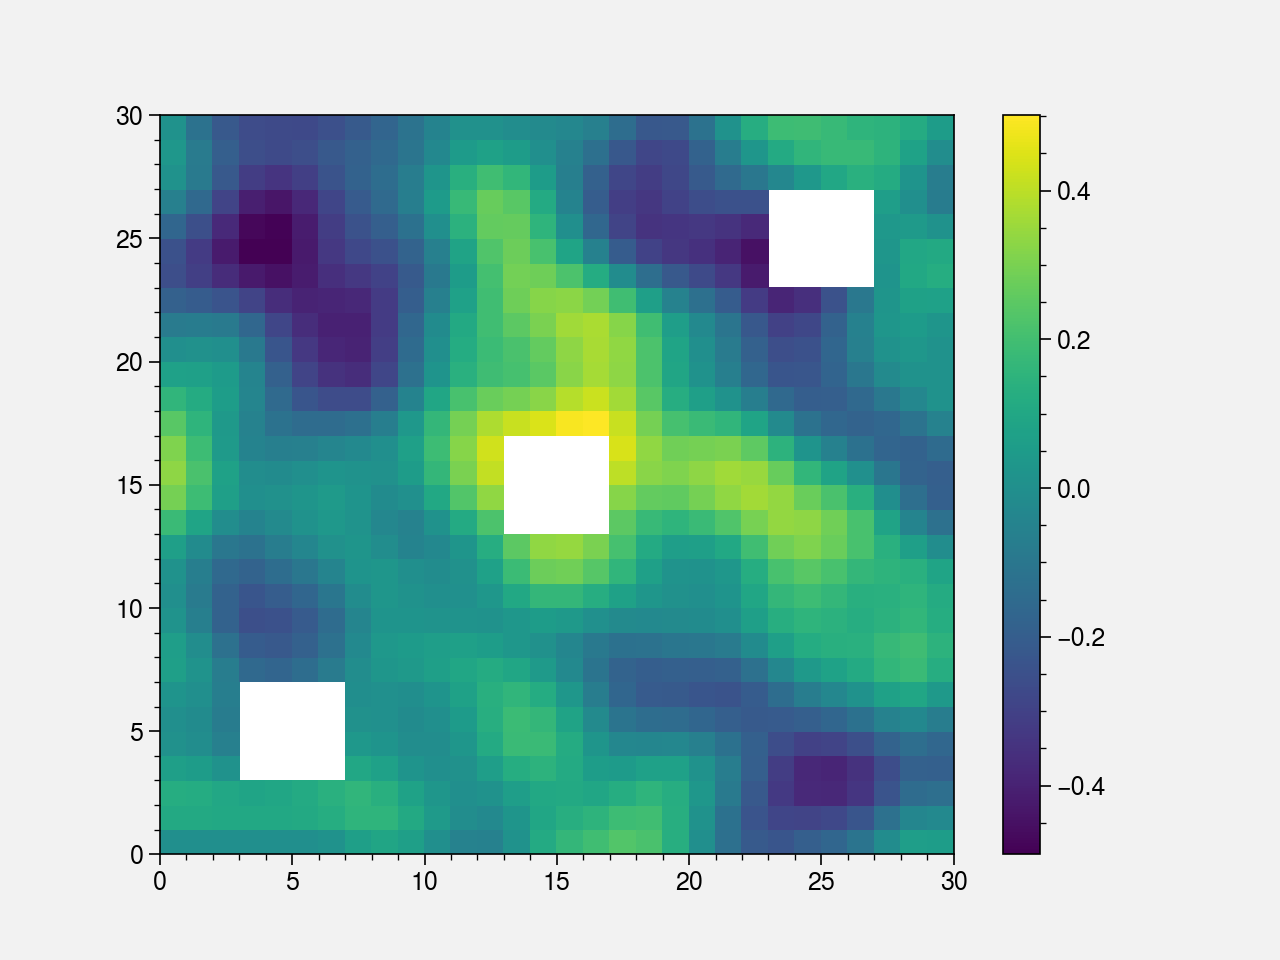

In [16]:
shape = (30,30)
scale = 10.0
octaves = 2
persistence = 0.5
lacunarity = 2.0

world = np.zeros(shape)
for i in range(shape[0]):
    for j in range(shape[1]):
        world[i][j] = noise.pnoise2(i/scale, j/scale, octaves = 2)
mask = np.zeros(world.shape)
mask[3:7, 3:7], mask[13:17, 13:17], mask[23:27, 23:27] = np.ones(3)

world = np.ma.masked_array(world, mask = mask, fill_value= np.nan)
plt.pcolormesh(world, cmap= 'viridis',)
plt.colorbar()
plt.show()

In [17]:
window = 5
kernel = np.ones((1, window))/np.float(window)
nan = convolve2dnan(world,kernel,max_missing=.99,verbose=True)
nan2=  convolve2dnan(world,kernel,max_missing=.9,verbose=True)
astro = convolve(world, kernel)
scip = np.ma.masked_array(convolve2d(world.filled(), kernel,mode='same', boundary='symm'))


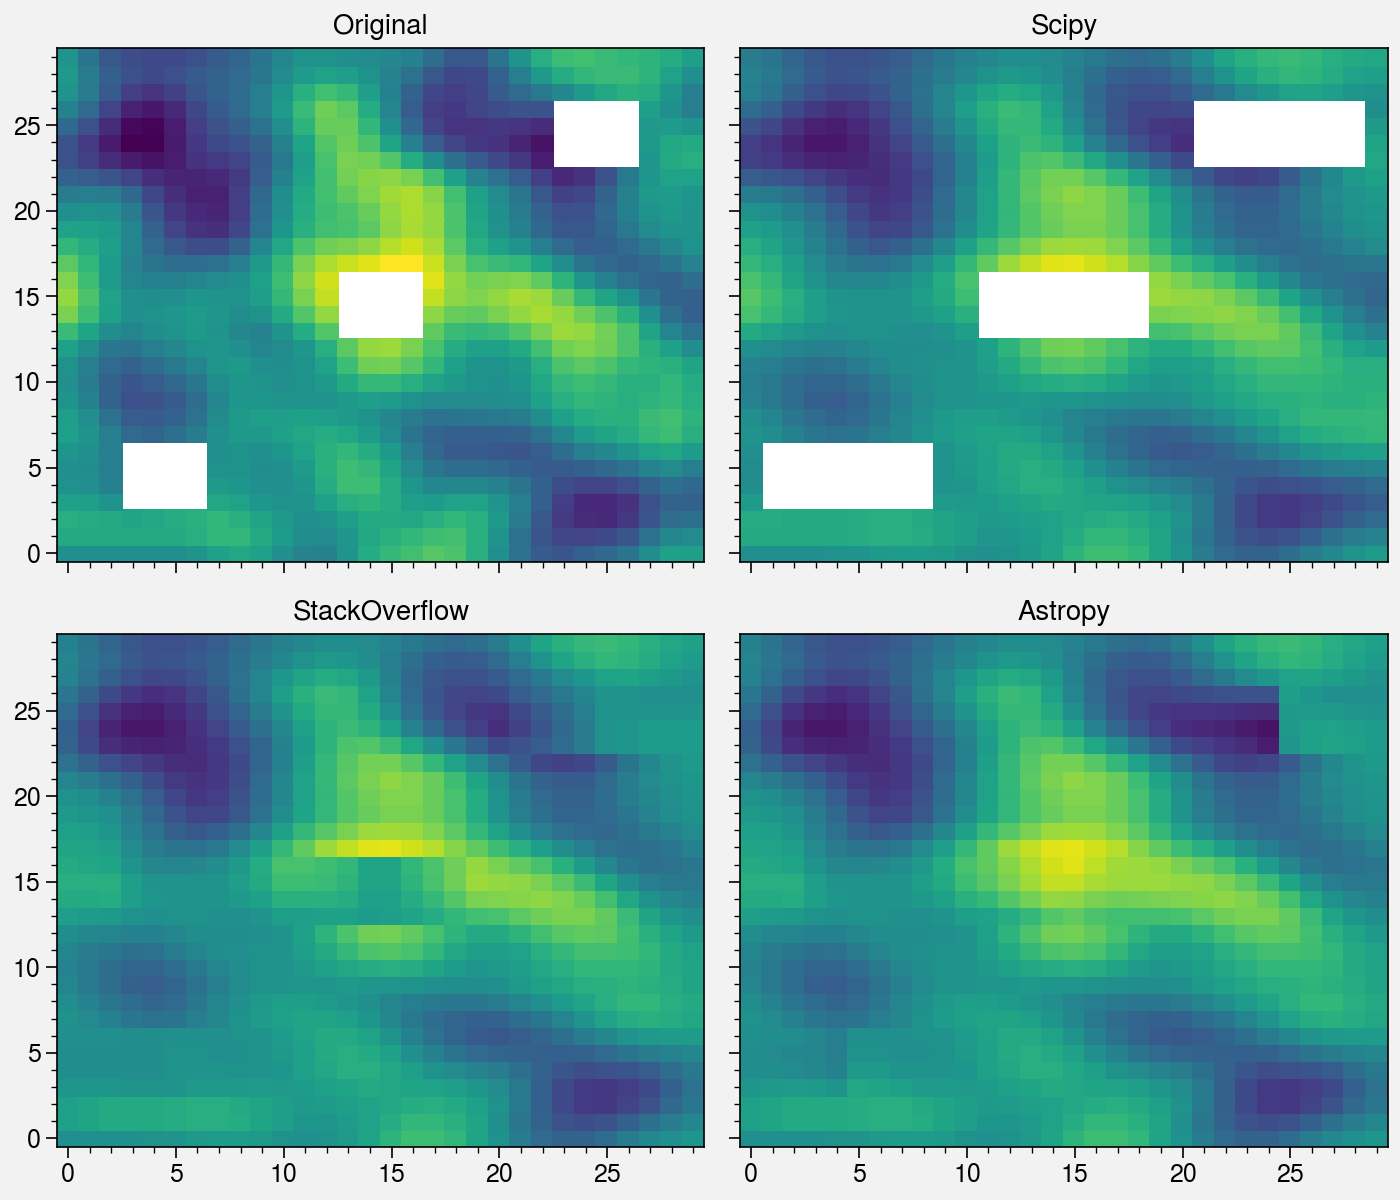

In [20]:
N =100
fig, axs= plot.subplots(nrows = 2, ncols = 2, figsize = (7,6))
fields = [world, scip, nan, astro]
titles = ['Original', 'Scipy', 'StackOverflow', 'Astropy']
for i, field in enumerate(fields):
    axs[i].pcolormesh(field, cmap = 'viridis', vmin = -.5, vmax =.5, N = N)
    axs[i].format(title = titles[i])
plot.show()

### Notes:

- The Scipy convolution is contagious for nans, they are spread along conv. dir
- You could fill the field with zeros but this obviously influences the values around it
- The stack overflow answer has a tunable missing threshold, but the missing values are understimated
- Astropy interpolates the missing data and seems to preserve the high values, clearly the best option for identifying valid meteorological data